TODO
- label smoothing
- paramterize tokens with sentencepiece
- proper padding and shifting of input

# Boilerplate

In [1]:
import sys; sys.path.insert(0, '..')

In [2]:
TRAINING_DIRECTORY = '../data/preprocessed_stories'
EXTENSION = '.clean'
N_TRAIN_FILES = 40000
N_TEST_FILES = 500
TOKENS_PER_BATCH = 4096

In [3]:
# # show tensor2tensor hparams for summarization for reference
# import tensor2tensor.models.transformer
# from tensor2tensor.utils.registry import hparams
# params = hparams('transformer_prepend')()
# for k, v in sorted(vars(params).items(), key=lambda tup: tup[0]):
#     if not k.startswith('_') and not callable(v):
#         print(f'{k}={v!r}')

# Read in files

In [4]:
import glob

In [5]:
FILES = glob.glob('%s/*%s' % (TRAINING_DIRECTORY, EXTENSION))
print(len(FILES))
FILES[:10]

312085


['../data/preprocessed_stories/000064fee589e5607c1534a69f852d37b4936cca.clean',
 '../data/preprocessed_stories/0000800d9058217f6509d7e63ad475e2de0da611.clean',
 '../data/preprocessed_stories/0000bf554ca24b0c72178403b54c0cca62d9faf8.clean',
 '../data/preprocessed_stories/0000dfd9f52a470b9f29957686c2704b68cd0635.clean',
 '../data/preprocessed_stories/000128cbd36642ced67ac90bd7d4d1dd5e8cf554.clean',
 '../data/preprocessed_stories/0001d1afc246a7964130f43ae940af6bc6c57f01.clean',
 '../data/preprocessed_stories/0001d4ce3598e37f20a47fe609736f72e5d73467.clean',
 '../data/preprocessed_stories/0001dc22494415d03319a6833a00cd9c559f1395.clean',
 '../data/preprocessed_stories/0001f1fcec4ca8bc7e278607ba0e31e5cc046e66.clean',
 '../data/preprocessed_stories/0002067d13d3ca304e0bc98d04dde85d4091c55e.clean']

In [6]:
TRAIN_FILES = FILES[:N_TRAIN_FILES]
TEST_FILES = FILES[N_TRAIN_FILES:N_TRAIN_FILES+N_TEST_FILES]

# Define batch generator

# Initialize Tokenizer

In [7]:
import numpy as np
import sentencepiece as spm

class BytePairEncoder:
    def __init__(self, vocab_size, model_name, *, model_file=None, vocab_file=None,
                 training_file=None, processor=None, **kwargs):
        self.vocab_size = vocab_size
        self.model_name = model_name
        self.training_file = training_file
        self.model_file = f'{self.model_name}.model' if model_file is None else model_file
        self.vocab_file = f'{self.model_name}.vocab' if vocab_file is None else vocab_file
        if processor is None:
            if training_file is None:
                raise ValueError('training_file cannot be None when processor is also None.')
            processor = self._fit(input=training_file, vocab_size=vocab_size,
                                  model_prefix=model_name, model_type='bpe',
                                  **kwargs)
        self.processor = processor
        
    def encode(self, text):
        return np.array(self.processor.EncodeAsIds(text))
    
    def encode_as_pieces(self, text):
        return self.processor.EncodeAsPieces(text)
    
    def decode(self, ids):
        return self.processor.DecodeIds(ids.tolist())
    
    def decode_pieces(self, pieces):
        return self.processor.DecodePieces(pieces)

    @classmethod
    def from_files(cls, model_file, vocab_file):
        model_name = model_file.partition('.')[0]
        processor = cls._load_model(model_file)
        for vocab_size, _ in enumerate(open(vocab_file), start=1): pass
        return cls(vocab_size=vocab_size, model_name=model_name, processor=processor,
                   model_file=model_file, vocab_file=vocab_file)
        
    @staticmethod
    def _load_model(filename):
        processor = spm.SentencePieceProcessor()
        processor.Load(filename)
        return processor
        
    def _fit(self, **kwargs):
        params = ' '.join([f'--{k}={v}' for k, v in kwargs.items()])
        spm.SentencePieceTrainer.Train(params)
        processor = self._load_model(self.model_file)
        return processor

In [8]:
# trained in byte-pair-encoding
TOKENIZER = BytePairEncoder.from_files('summarizer.model', 'summarizer.vocab')

In [9]:
TOKENIZER.vocab_size

30000

# Tokenize files

In [10]:
class TrainingExample:
    """Simple container to keep track of training data. Useful for debugging."""
    def __init__(self, item, context_text, target_text, context_tokens,
                 target_tokens, filename):
        self.item = item
        self.context_text = context_text
        self.target_text = target_text
        self.context_tokens = context_tokens
        self.target_tokens = target_tokens
        self.filename = filename
        
    def __len__(self):
        return len(self.context_tokens) + len(self.target_tokens)

def load_files(files, tokenizer):
    """Load and tokenize files."""
    training_examples = []
    for file in files:
        with open(file) as f:
            context_text, target_text = f.read().split('\t')
        context_tokens = tokenizer(context_text)
        target_tokens = tokenizer(target_text)
        example = TrainingExample(file, context_text, target_text,
                                  context_tokens, target_tokens,
                                  file)
        training_examples.append(example)
    return training_examples

In [11]:
%%time
from tqdm import tqdm_notebook as tqdm
TRAINING_EXAMPLES = load_files(tqdm(TRAIN_FILES[:1000]), TOKENIZER.encode)
# sort files by number of tokens to reduce padding
TRAINING_EXAMPLES = sorted(TRAINING_EXAMPLES, key=lambda x: len(x))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


CPU times: user 3.27 s, sys: 56.9 ms, total: 3.33 s
Wall time: 3.33 s


In [12]:
[len(x) for x in TRAINING_EXAMPLES]

[28,
 134,
 147,
 171,
 176,
 181,
 182,
 204,
 209,
 220,
 224,
 237,
 238,
 240,
 240,
 251,
 255,
 256,
 260,
 266,
 266,
 276,
 277,
 279,
 279,
 284,
 286,
 290,
 297,
 298,
 299,
 300,
 300,
 306,
 310,
 314,
 316,
 324,
 327,
 328,
 328,
 331,
 334,
 339,
 340,
 340,
 342,
 345,
 345,
 353,
 360,
 361,
 361,
 362,
 368,
 368,
 371,
 371,
 373,
 373,
 373,
 374,
 375,
 375,
 375,
 376,
 377,
 378,
 379,
 380,
 380,
 382,
 383,
 386,
 388,
 388,
 390,
 391,
 392,
 392,
 394,
 395,
 395,
 396,
 396,
 396,
 397,
 400,
 401,
 401,
 408,
 408,
 408,
 409,
 412,
 419,
 419,
 420,
 421,
 424,
 426,
 427,
 427,
 428,
 428,
 428,
 428,
 430,
 431,
 432,
 438,
 438,
 439,
 440,
 442,
 443,
 443,
 444,
 445,
 445,
 446,
 446,
 446,
 447,
 449,
 451,
 453,
 453,
 454,
 454,
 455,
 459,
 460,
 461,
 461,
 463,
 466,
 470,
 470,
 471,
 472,
 476,
 476,
 478,
 479,
 479,
 481,
 482,
 482,
 482,
 483,
 486,
 489,
 490,
 490,
 492,
 496,
 497,
 499,
 499,
 499,
 499,
 500,
 501,
 501,
 503,
 503,

# Take a look at batches

In [13]:
import numpy as np
from data import BaseBatchGenerator
from keras.preprocessing.sequence import pad_sequences


class SummaryBatchGenerator(BaseBatchGenerator):
    def __init__(self, max_context_len=None, max_target_len=None, pad_token=0,
                 bos_token=1, eos_token=2, prepend=False):
        self.max_context_len = max_context_len
        self.max_target_len = max_target_len
        self.bos_token = bos_token
        self.eos_token = eos_token
        self.pad_token = pad_token
        self.prepend = prepend

    def generate_steps(self, item):
        example = item  # alias
        if self.max_target_len is not None \
                and len(example.target_tokens) > self.max_target_len:
            return []
        if self.max_context_len is not None:
            encoder_tokens = example.context_tokens[:self.max_context_len]
        else:
            encoder_tokens = example.context_tokens
        if self.prepend:
            decoder_tokens = np.append(example.context_tokens, self.eos_token)
        else:
            decoder_tokens = np.array([])
        decoder_tokens = np.append(decoder_tokens, example.target_tokens)
        decoder_tokens = np.append(decoder_tokens, self.eos_token)
        training_step = encoder_tokens, decoder_tokens, len(example)
        return [training_step]

    def generate_batches(self, steps, batch_size):
        batches = []
        min_batch_size = 0.95 * batch_size
        max_batch_size = 1.05 * batch_size
        step_sizes = [size for _, _, size in steps]
        current_batch_x1s = []
        current_batch_x2s = []
        current_batch_size = 0
        items = enumerate(zip(steps, step_sizes, step_sizes[1:]))
        max_used_i = 0
        for i, (step, step_size, next_step_size) in items:
            if step_size > max_batch_size:
                print(f'skipping step with size {step_size}')
                continue
            encoder_tokens, decoder_tokens, _ = step
            current_batch_x1s.append(encoder_tokens)
            current_batch_x2s.append(decoder_tokens)
            current_batch_size += step_size
            if min_batch_size <= current_batch_size <= max_batch_size or \
                    current_batch_size + next_step_size > max_batch_size:
                max_used_i = i
                x1 = pad_sequences(current_batch_x1s, value=self.pad_token)
                x2 = pad_sequences(current_batch_x2s, value=self.pad_token)
                X = [x1, x2[:,:-1]]
                y = x2[:,1:]
                batches.append((X, y))
                current_batch_size = 0
                current_batch_x1s, current_batch_x2s = [], []
            # if there aren't enough steps left to create a full sized batch
            # then break
            if sum(step_sizes[i+1:]) < batch_size:
                break
        return (batches, steps[max_used_i+1:]) if max_used_i > 0 else (batches, steps)


Using TensorFlow backend.


In [14]:
BATCH_GENERATOR = SummaryBatchGenerator(pad_token=TOKENIZER.vocab_size, prepend=True)

In [15]:
%%time
epoch_generator = BATCH_GENERATOR.generate_epoch(TRAINING_EXAMPLES, batch_size=TOKENS_PER_BATCH)

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 11 µs


In [16]:
epoch = list(epoch_generator)

In [17]:
len(epoch)

244

In [18]:
# TODO: why + 1
# TOOD: if we skip a training example because it is too large this will fail eroneously
assert sum(x1.shape[0] for (x1, _), _ in epoch) == len(TRAINING_EXAMPLES) + 1, \
    'number of steps in batch does not equal number of examples'

In [19]:
# def view_training_steps(x1, x2, y):
#     print(TOKENIZER.decode(x1))
#     print('\n')
#     print(TOKENIZER.decode(x2))
#     print('\n')
#     print(TOKENIZER.decode(y))

In [20]:
# (x1, x2), y = epoch[0]
# view_training_steps(x1[0], x2[0], y[0])

In [21]:
# now that we're happy with the batch generator create one that goes forever
TRAIN_GEN = BATCH_GENERATOR.generate_forever(
    TRAINING_EXAMPLES,
    batch_size=TOKENS_PER_BATCH,
    shuffle=False)

# Training

## Define functions for loss/metrics/callbacks

In [22]:
import tensorflow as tf
import keras.backend as K

# on custom implementation rather than keras see
# https://github.com/tensorflow/tensorflow/issues/17150
def sparse_categorical_crossentropy(y_true, y_pred):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

def perplexity(y_true, y_pred):
    cross_entropy = sparse_categorical_crossentropy(y_true, y_pred)
    return K.exp(cross_entropy)

In [23]:
import numpy as np

# see
# https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/utils/learning_rate.py
class LRScheduler:
    """Stateful learning rate scheduler.
    
    Useful if training is stopped and then resumed so that scheduling
    resumes considering the epoch during which training was interrupted.
    """
    def __init__(self, d_model, warmup_steps, learning_rate):
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.learning_rate = learning_rate
        self.epoch = 1
        self.initial_lr = self.lr()

    def lr(self, *args):
        scalar = 5000 \
               * self.d_model**-0.5 \
               * min(self.epoch * self.warmup_steps**-1.5, self.epoch**-0.5)
        self.epoch += 1
        return 0.002 * scalar * self.learning_rate

## Define validation set

In [24]:
%%time
VALIDATION_EXAMPLES = load_files(tqdm(TEST_FILES[:1000]), TOKENIZER.encode)
# sort files by number of tokens to reduce padding
VALIDATION_EXAMPLES = sorted(VALIDATION_EXAMPLES, key=lambda x: len(x))
TEST_GEN = BATCH_GENERATOR.generate_forever(VALIDATION_EXAMPLES, batch_size=TOKENS_PER_BATCH, shuffle=False)
N_VALIDATION_STEPS = BATCH_GENERATOR.batches_per_epoch(VALIDATION_EXAMPLES, batch_size=TOKENS_PER_BATCH)

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))


CPU times: user 1.74 s, sys: 31.6 ms, total: 1.77 s
Wall time: 1.77 s


## Training configs

In [25]:
from keras.optimizers import adam
from keras.callbacks import LearningRateScheduler

In [26]:
# # model architecture
N_HEADS = 8
N_LAYERS = 6
D_MODEL = 64*N_HEADS
SENTENCE_LEN = None
VOCAB_SIZE = TOKENIZER.vocab_size + 1  # +1 accounts for pad token
DROPOUT = 0.1
OUTPUT_ACTIVATION = 'linear'  # temporary workaround for keras bug - see above

# learning rate
WARMUP_STEPS = 8_000
LEARNING_RATE = 0.2
LEARNING_RATE_SCHEDULER = LRScheduler(D_MODEL, WARMUP_STEPS, LEARNING_RATE)

# # optimization
# # https://arxiv.org/pdf/1804.00247.pdf
BETA_1 = 0.9
BETA_2 = 0.98
EPSILON = 1e-9
OPTIMIZER = adam(lr=LEARNING_RATE_SCHEDULER.initial_lr, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON)
METRICS = [sparse_categorical_crossentropy]
LOSS = perplexity

# # batch training
N_TRAIN_STEPS = 1_000
CALLBACKS = [LearningRateScheduler(LEARNING_RATE_SCHEDULER.lr)]

## Training

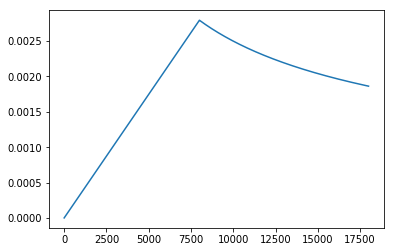

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
scheduler = LRScheduler(D_MODEL, WARMUP_STEPS, LEARNING_RATE)
learning_rates = [scheduler.lr()
                  for _ in range(WARMUP_STEPS+10_000)]
plt.plot(learning_rates)

In [28]:
from model import Transformer
model = Transformer(
    n_heads=N_HEADS,
    encoder_layers=N_LAYERS,
    decoder_layers=N_LAYERS,
    d_model=D_MODEL,
    vocab_size=VOCAB_SIZE,
    sequence_len=SENTENCE_LEN,
    dropout=DROPOUT,
    output_activation=OUTPUT_ACTIVATION)

In [29]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
encoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     1920064     encoder_input[0][0]              
                                                                 decoder_input[0][0]              
__________________________________________________________________________________________________
positional_encoding_1 (Position (None, None, 64)     0           embedding[0][0]                  
          

In [30]:
TARGET_PLACEHOLDER = tf.placeholder(dtype='int32', shape=(None, SENTENCE_LEN))
model.compile(
    loss=LOSS,
    optimizer=OPTIMIZER,
    metrics=METRICS,
    target_tensors=[TARGET_PLACEHOLDER])

In [31]:
# print loss values for reference
def display_loss_reference():
    format_ = 'perplexity: %20s\tentropy: %20s'
    upper_limit = np.log(VOCAB_SIZE)
    print(format_ % (np.exp(upper_limit), upper_limit))
    for i in reversed(range(int(np.floor(upper_limit))+1)):
        print(format_ % (np.exp(i), i))
display_loss_reference()

perplexity:    30000.99999999999	entropy:   10.308985993422082
perplexity:   22026.465794806718	entropy:                   10
perplexity:    8103.083927575384	entropy:                    9
perplexity:   2980.9579870417283	entropy:                    8
perplexity:   1096.6331584284585	entropy:                    7
perplexity:    403.4287934927351	entropy:                    6
perplexity:    148.4131591025766	entropy:                    5
perplexity:   54.598150033144236	entropy:                    4
perplexity:   20.085536923187668	entropy:                    3
perplexity:     7.38905609893065	entropy:                    2
perplexity:    2.718281828459045	entropy:                    1
perplexity:                  1.0	entropy:                    0


In [32]:
model.fit_generator(
    TRAIN_GEN,
    steps_per_epoch=N_TRAIN_STEPS,
    validation_data=TEST_GEN,
    validation_steps=N_VALIDATION_STEPS,
    callbacks=CALLBACKS)

Epoch 1/1
   8/1000 [..............................] - ETA: 1:02:42 - loss: 30489.7441 - sparse_categorical_crossentropy: 10.3199

KeyboardInterrupt: 